In [1]:
# 下載資料
# !gdown --id '14CqX3OfY9aUbhGp4OpdSHLvq2321fUB7' --output data.zip
# 解壓縮
# !unzip data.zip

In [2]:
import os
# 讀取 label.csv
import pandas as pd
# 讀取圖片
from PIL import Image
import numpy as np

import torch
# Loss function
import torch.nn.functional as F
# 讀取資料
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
# 載入預訓練的模型
import torchvision.models as models
# 將資料轉換成符合預訓練模型的形式
import torchvision.transforms as transforms
# 顯示圖片
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 實作一個繼承 torch.utils.data.Dataset 的 Class 來讀取圖片
class Adverdataset(Dataset):
    def __init__(self, root, label, transforms):
        # 圖片所在的資料夾
        self.root = root
        # 由 main function 傳入的 label
        self.label = torch.from_numpy(label).long()
        # 由 Attacker 傳入的 transforms 將輸入的圖片轉換成符合預訓練模型的形式
        self.transforms = transforms
        # 圖片檔案名稱的 list
        self.fnames = []

        for i in range(200):
            self.fnames.append("{:03d}".format(i))

    def __getitem__(self, idx):
        # 利用路徑讀取圖片
        img = Image.open(os.path.join(self.root, self.fnames[idx] + '.png'))
        # 將輸入的圖片轉換成符合預訓練模型的形式
        img = self.transforms(img)
        # 圖片相對應的 label
        label = self.label[idx]
        return img, label
    
    def __len__(self):
        # 由於已知這次的資料總共有 200 張圖片 所以回傳 200
        return 200

In [4]:
class Attacker:
    def __init__(self, img_dir, label):
        # 讀入預訓練模型 vgg16
        self.model = models.densenet121(pretrained=True)
        self.model.to(DEVICE)
        self.model.eval()
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        # 把圖片 normalize 到 0~1 之間 mean 0 variance 1
        self.normalize = transforms.Normalize(self.mean, self.std, inplace=False)
        transform = transforms.Compose([
            transforms.Resize((224, 224), interpolation=3),
            transforms.ToTensor(),
            self.normalize
        ])
        # 利用 Adverdataset 這個 class 讀取資料
        self.dataset = Adverdataset('./data/images', label, transform)
        
        self.loader = torch.utils.data.DataLoader(
                self.dataset,
                batch_size = 1,
                shuffle = False)

    # FGSM 攻擊
    def fgsm_attack(self, image, epsilon, data_grad):
        # 找出 gradient 的方向
        sign_data_grad = data_grad.sign()
        # 將圖片加上 gradient 方向乘上 epsilon 的 noise
        perturbed_image = image + epsilon * sign_data_grad
        # 將圖片超過 1 或是小於 0 的部分 clip 掉
#         perturbed_image = torch.clamp(perturbed_image, 0, 1)
        return perturbed_image
    
    def attack(self, epsilon):
        # 存下一些成功攻擊後的圖片 以便之後顯示
        adv_results = []
        wrong, fail, success = 0, 0, 0
        for (data, target) in self.loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            data_raw = data
            data.requires_grad = True
            # 將圖片丟入 model 進行測試 得出相對應的 class
            output = self.model(data)
            init_pred = output.max(1, keepdim=True)[1]

            if init_pred.item() != target.item():
                # 如果 class 錯誤 就不進行攻擊
                wrong += 1
                perturbed_data = data_raw
                final_pred = init_pred
            else:
                # 如果 class 正確 就開始計算 gradient 進行 FGSM 攻擊
                loss = F.nll_loss(output, target)
                self.model.zero_grad()
                loss.backward()
                data_grad = data.grad.data
                perturbed_data = self.fgsm_attack(data, epsilon, data_grad)

                # 再將加入 noise 的圖片丟入 model 進行測試 得出相對應的 class        
                output = self.model(perturbed_data)
                final_pred = output.max(1, keepdim=True)[1]

                if final_pred.item() == target.item():
                    # 辨識結果還是正確 攻擊失敗
                    fail += 1
                else:
                    # 辨識結果失敗 攻擊成功
                    success += 1
            # 將圖片存入
            adv_ex = perturbed_data * torch.tensor(self.std, device=DEVICE).view(3, 1, 1) + torch.tensor(self.mean, device=DEVICE).view(3, 1, 1)
            adv_ex = adv_ex.squeeze().detach().cpu().numpy()
            np.clip(adv_ex, 0, 1, out=adv_ex)
            data_raw = data_raw * torch.tensor(self.std, device=DEVICE).view(3, 1, 1) + torch.tensor(self.mean, device=DEVICE).view(3, 1, 1)
            data_raw = data_raw.squeeze().detach().cpu().numpy()
            adv_results.append( (init_pred.item(), final_pred.item(), data_raw, adv_ex) )
        final_acc = (fail / (wrong + success + fail))
        
        print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, fail, len(self.loader), final_acc))
        return adv_results, final_acc


In [5]:
# 讀入圖片相對應的 label
df = pd.read_csv("./data/labels.csv")
df = df.loc[:, 'TrueLabel'].to_numpy()
label_name = pd.read_csv("./data/categories.csv")
label_name = label_name.loc[:, 'CategoryName'].to_numpy()
# new 一個 Attacker class
attacker = Attacker('./data/images', df)
# 要嘗試的 epsilon
epsilons = [0.137]

accuracies, examples = [], []
results = []

# 進行攻擊 並存起正確率和攻擊成功的圖片
for eps in epsilons:
    res, acc = attacker.attack(eps)
    accuracies.append(acc)
    examples.append(res[:5])
    results.append(res)
    L_inf = 0
    for img in res:
        L_inf += np.linalg.norm((img[2] - img[3]).reshape(224 * 224 * 3), ord=np.inf)
    L_inf /= 200
    L_inf *= 255
    print(f'L-inf = {L_inf}\n')

Epsilon: 0.137	Test Accuracy = 19 / 200 = 0.095
L-inf = 7.400122292339802



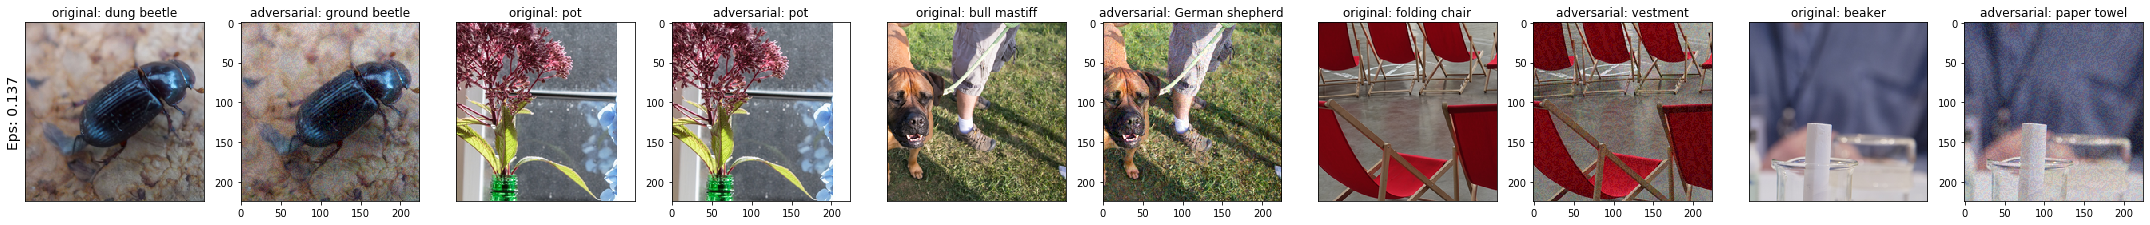

In [6]:
%matplotlib inline
# 顯示圖片
cnt = 0
plt.figure(figsize=(30, 30))
for i in range(len(epsilons)):
    try:
        os.mkdir(f'results/{epsilons[i]}')
    except FileExistsError:
        pass
    for j, img in enumerate(results[i]):
        img = img[3] * 255
        img = img.astype('uint8')
        img = np.transpose(img, (1, 2, 0))
        img = Image.fromarray(img, 'RGB')
        img.save(f'results/{epsilons[i]}/%03d.png' % j)

    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]) * 2,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig, adv, orig_img, ex = examples[i][j]
        # plt.title("{} -> {}".format(orig, adv))
        plt.title("original: {}".format(label_name[orig].split(',')[0]))
        orig_img = np.transpose(orig_img, (1, 2, 0))
        plt.imshow(orig_img)
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]) * 2,cnt)
        plt.title("adversarial: {}".format(label_name[adv].split(',')[0]))
        ex = np.transpose(ex, (1, 2, 0))
        plt.imshow(ex)
plt.tight_layout()
plt.show()

In [7]:
torch.cuda.empty_cache()